# Quantum Maze Solver

[MazeCell(0, 2), MazeCell(0, 1), MazeCell(1, 1), MazeCell(2, 1), MazeCell(3, 1), MazeCell(3, 2), MazeCell(4, 2), MazeCell(4, 3), MazeCell(4, 4)]


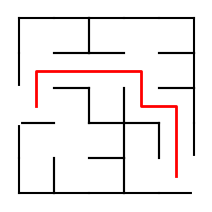

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(1, 3), MazeCell(2, 3), MazeCell(3, 3), MazeCell(4, 3), MazeCell(4, 4)]


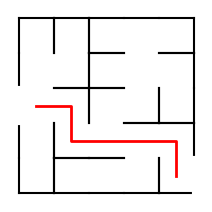

[MazeCell(0, 2), MazeCell(0, 3), MazeCell(1, 3), MazeCell(1, 2), MazeCell(2, 2), MazeCell(3, 2), MazeCell(3, 3), MazeCell(4, 3), MazeCell(4, 4)]


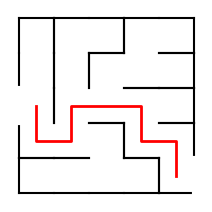

[MazeCell(0, 2), MazeCell(0, 3), MazeCell(1, 3), MazeCell(2, 3), MazeCell(3, 3), MazeCell(3, 4), MazeCell(4, 4)]


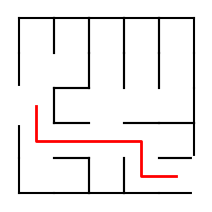

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(3, 2), MazeCell(3, 3), MazeCell(4, 3), MazeCell(4, 4)]


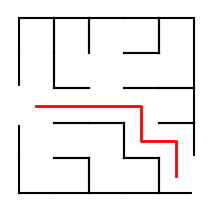

[MazeCell(0, 2), MazeCell(0, 1), MazeCell(1, 1), MazeCell(2, 1), MazeCell(3, 1), MazeCell(3, 2), MazeCell(4, 2), MazeCell(4, 3), MazeCell(4, 4)]


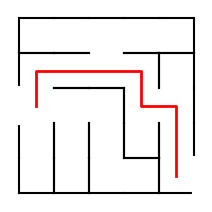

[MazeCell(0, 2), MazeCell(0, 1), MazeCell(1, 1), MazeCell(2, 1), MazeCell(3, 1), MazeCell(4, 1), MazeCell(4, 2), MazeCell(4, 3), MazeCell(4, 4)]


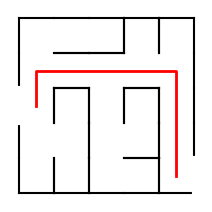

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(3, 2), MazeCell(4, 2), MazeCell(4, 3), MazeCell(4, 4)]


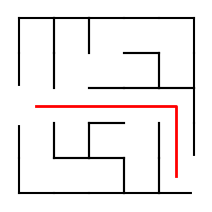

[MazeCell(0, 2), MazeCell(0, 3), MazeCell(1, 3), MazeCell(2, 3), MazeCell(2, 4), MazeCell(3, 4), MazeCell(4, 4)]


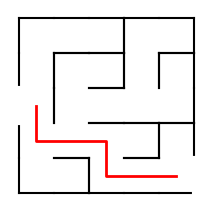

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(1, 3), MazeCell(1, 4), MazeCell(2, 4), MazeCell(3, 4), MazeCell(4, 4)]


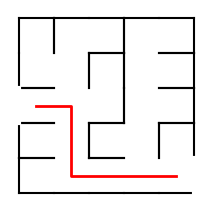

[MazeCell(0, 2), MazeCell(0, 1), MazeCell(1, 1), MazeCell(1, 2), MazeCell(1, 3), MazeCell(1, 4), MazeCell(2, 4), MazeCell(3, 4), MazeCell(4, 4)]


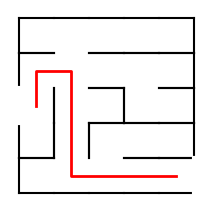

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(2, 3), MazeCell(2, 4), MazeCell(3, 4), MazeCell(4, 4)]


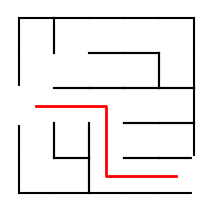

[MazeCell(0, 2), MazeCell(0, 3), MazeCell(1, 3), MazeCell(2, 3), MazeCell(3, 3), MazeCell(4, 3), MazeCell(4, 4)]


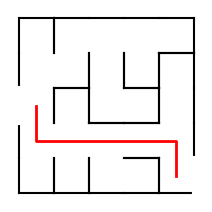

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(1, 3), MazeCell(2, 3), MazeCell(3, 3), MazeCell(3, 4), MazeCell(4, 4)]


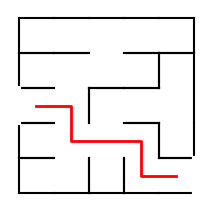

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(2, 3), MazeCell(3, 3), MazeCell(3, 4), MazeCell(4, 4)]


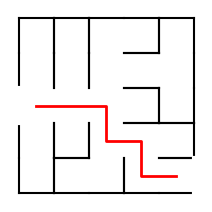

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(3, 2), MazeCell(4, 2), MazeCell(4, 3), MazeCell(4, 4)]


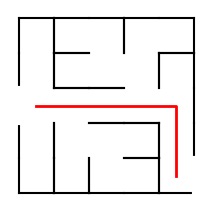

[MazeCell(0, 2), MazeCell(0, 3), MazeCell(0, 4), MazeCell(1, 4), MazeCell(2, 4), MazeCell(3, 4), MazeCell(4, 4)]


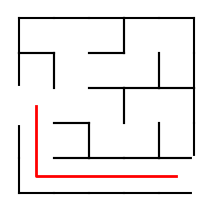

[MazeCell(0, 2), MazeCell(0, 1), MazeCell(1, 1), MazeCell(2, 1), MazeCell(3, 1), MazeCell(3, 2), MazeCell(3, 3), MazeCell(4, 3), MazeCell(4, 4)]


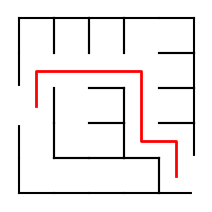

[MazeCell(0, 2), MazeCell(0, 3), MazeCell(1, 3), MazeCell(2, 3), MazeCell(2, 4), MazeCell(3, 4), MazeCell(4, 4)]


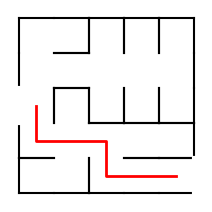

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(2, 3), MazeCell(3, 3), MazeCell(4, 3), MazeCell(4, 4)]


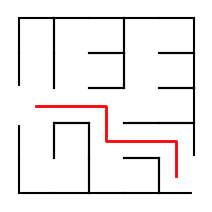

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(3, 2), MazeCell(4, 2), MazeCell(4, 3), MazeCell(4, 4)]


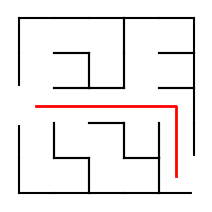

[MazeCell(0, 2), MazeCell(0, 1), MazeCell(1, 1), MazeCell(1, 2), MazeCell(1, 3), MazeCell(2, 3), MazeCell(3, 3), MazeCell(4, 3), MazeCell(4, 4)]


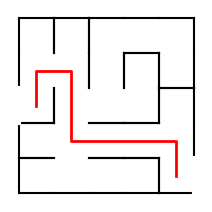

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(2, 3), MazeCell(3, 3), MazeCell(4, 3), MazeCell(4, 4)]


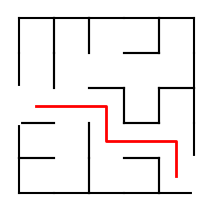

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(2, 3), MazeCell(2, 4), MazeCell(3, 4), MazeCell(4, 4)]


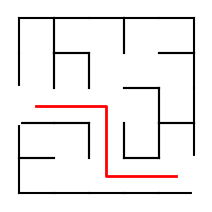

[MazeCell(0, 2), MazeCell(0, 3), MazeCell(1, 3), MazeCell(1, 2), MazeCell(2, 2), MazeCell(3, 2), MazeCell(4, 2), MazeCell(4, 3), MazeCell(4, 4)]


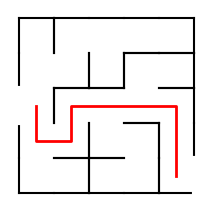

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(3, 2), MazeCell(4, 2), MazeCell(4, 3), MazeCell(4, 4)]


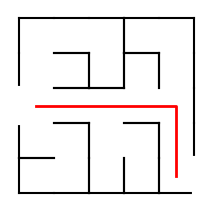

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(2, 3), MazeCell(2, 4), MazeCell(3, 4), MazeCell(4, 4)]


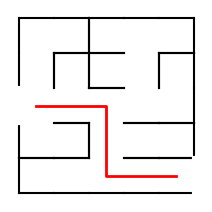

[MazeCell(0, 2), MazeCell(0, 3), MazeCell(0, 4), MazeCell(1, 4), MazeCell(2, 4), MazeCell(2, 3), MazeCell(3, 3), MazeCell(3, 4), MazeCell(4, 4)]


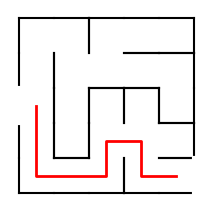

[MazeCell(0, 2), MazeCell(0, 3), MazeCell(1, 3), MazeCell(2, 3), MazeCell(3, 3), MazeCell(3, 4), MazeCell(4, 4)]


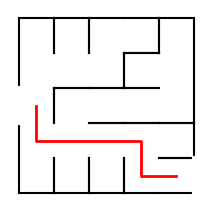

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(3, 2), MazeCell(3, 3), MazeCell(3, 4), MazeCell(4, 4)]


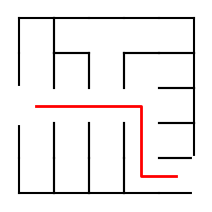

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(1, 3), MazeCell(1, 4), MazeCell(2, 4), MazeCell(3, 4), MazeCell(4, 4)]


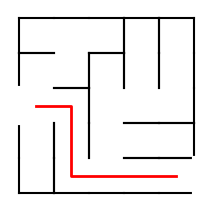

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(1, 3), MazeCell(2, 3), MazeCell(2, 2), MazeCell(3, 2), MazeCell(3, 3), MazeCell(3, 4), MazeCell(4, 4)]


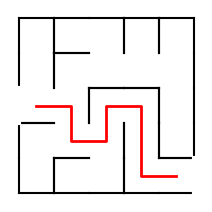

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(1, 3), MazeCell(2, 3), MazeCell(3, 3), MazeCell(4, 3), MazeCell(4, 4)]


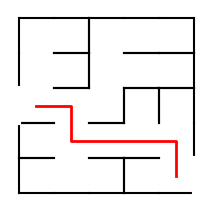

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(2, 3), MazeCell(3, 3), MazeCell(4, 3), MazeCell(4, 4)]


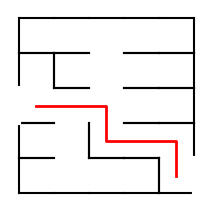

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(1, 3), MazeCell(1, 4), MazeCell(2, 4), MazeCell(3, 4), MazeCell(4, 4)]


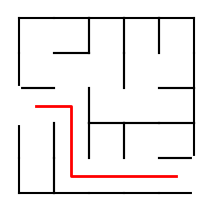

[MazeCell(0, 2), MazeCell(0, 1), MazeCell(1, 1), MazeCell(2, 1), MazeCell(3, 1), MazeCell(3, 2), MazeCell(2, 2), MazeCell(2, 3), MazeCell(3, 3), MazeCell(3, 4), MazeCell(4, 4)]


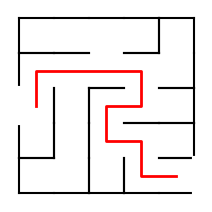

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(1, 3), MazeCell(2, 3), MazeCell(3, 3), MazeCell(4, 3), MazeCell(4, 4)]


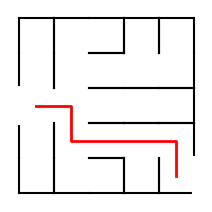

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(2, 3), MazeCell(3, 3), MazeCell(4, 3), MazeCell(4, 4)]


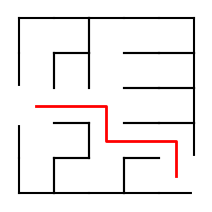

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(2, 3), MazeCell(2, 4), MazeCell(3, 4), MazeCell(4, 4)]


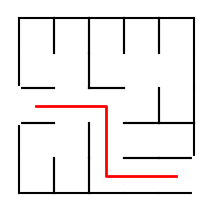

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(1, 3), MazeCell(2, 3), MazeCell(3, 3), MazeCell(4, 3), MazeCell(4, 4)]


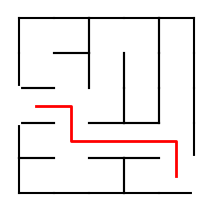

[MazeCell(0, 2), MazeCell(0, 3), MazeCell(1, 3), MazeCell(2, 3), MazeCell(3, 3), MazeCell(3, 4), MazeCell(4, 4)]


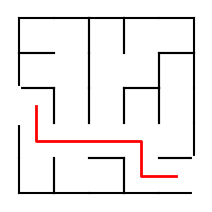

[MazeCell(0, 2), MazeCell(0, 3), MazeCell(1, 3), MazeCell(1, 4), MazeCell(2, 4), MazeCell(3, 4), MazeCell(4, 4)]


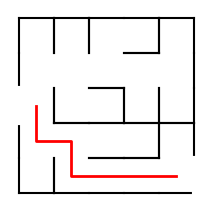

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(3, 2), MazeCell(4, 2), MazeCell(4, 3), MazeCell(4, 4)]


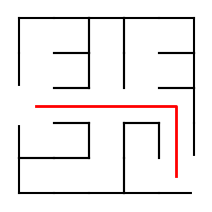

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(1, 3), MazeCell(2, 3), MazeCell(2, 4), MazeCell(3, 4), MazeCell(4, 4)]


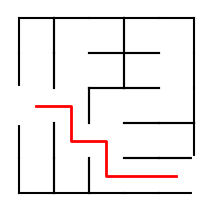

[MazeCell(0, 2), MazeCell(0, 3), MazeCell(0, 4), MazeCell(1, 4), MazeCell(2, 4), MazeCell(3, 4), MazeCell(4, 4)]


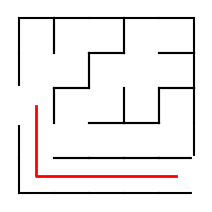

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(1, 3), MazeCell(1, 4), MazeCell(2, 4), MazeCell(3, 4), MazeCell(4, 4)]


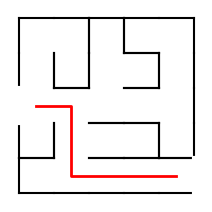

[MazeCell(0, 2), MazeCell(0, 1), MazeCell(1, 1), MazeCell(2, 1), MazeCell(3, 1), MazeCell(3, 2), MazeCell(3, 3), MazeCell(3, 4), MazeCell(4, 4)]


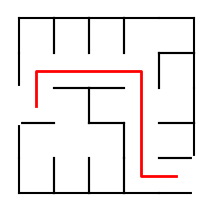

[MazeCell(0, 2), MazeCell(0, 3), MazeCell(1, 3), MazeCell(2, 3), MazeCell(2, 4), MazeCell(3, 4), MazeCell(4, 4)]


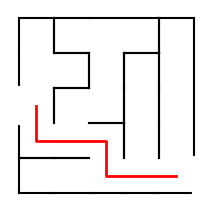

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(3, 2), MazeCell(4, 2), MazeCell(4, 3), MazeCell(4, 4)]


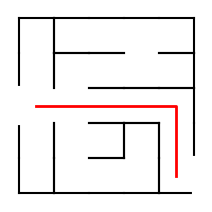

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(2, 3), MazeCell(2, 4), MazeCell(3, 4), MazeCell(4, 4)]


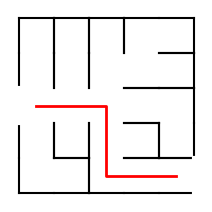

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(1, 3), MazeCell(2, 3), MazeCell(2, 4), MazeCell(3, 4), MazeCell(4, 4)]


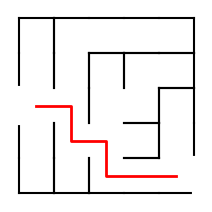

[MazeCell(0, 2), MazeCell(0, 3), MazeCell(0, 4), MazeCell(1, 4), MazeCell(2, 4), MazeCell(3, 4), MazeCell(4, 4)]


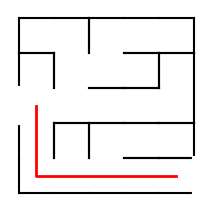

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(2, 3), MazeCell(3, 3), MazeCell(3, 2), MazeCell(4, 2), MazeCell(4, 3), MazeCell(4, 4)]


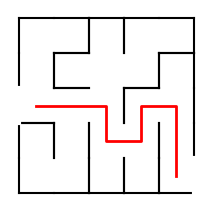

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(1, 3), MazeCell(1, 4), MazeCell(2, 4), MazeCell(3, 4), MazeCell(4, 4)]


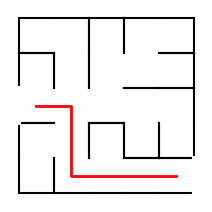

[MazeCell(0, 2), MazeCell(0, 3), MazeCell(1, 3), MazeCell(1, 2), MazeCell(2, 2), MazeCell(3, 2), MazeCell(4, 2), MazeCell(4, 3), MazeCell(4, 4)]


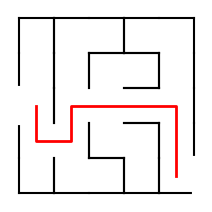

[MazeCell(0, 2), MazeCell(0, 3), MazeCell(0, 4), MazeCell(1, 4), MazeCell(2, 4), MazeCell(3, 4), MazeCell(4, 4)]


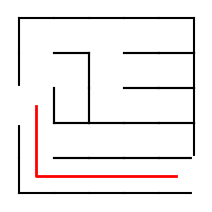

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(1, 3), MazeCell(2, 3), MazeCell(3, 3), MazeCell(4, 3), MazeCell(4, 4)]


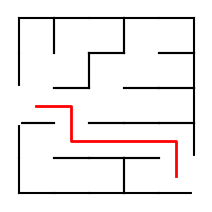

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(1, 1), MazeCell(2, 1), MazeCell(3, 1), MazeCell(3, 2), MazeCell(3, 3), MazeCell(3, 4), MazeCell(4, 4)]


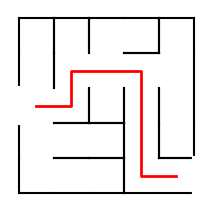

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(1, 3), MazeCell(1, 4), MazeCell(2, 4), MazeCell(3, 4), MazeCell(4, 4)]


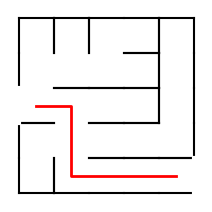

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(2, 3), MazeCell(3, 3), MazeCell(3, 4), MazeCell(4, 4)]


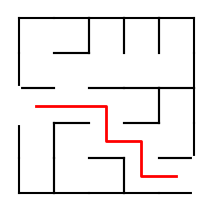

[MazeCell(0, 2), MazeCell(0, 1), MazeCell(0, 0), MazeCell(1, 0), MazeCell(2, 0), MazeCell(3, 0), MazeCell(3, 1), MazeCell(3, 2), MazeCell(3, 3), MazeCell(3, 4), MazeCell(4, 4)]


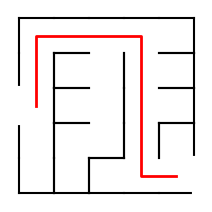

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(1, 3), MazeCell(2, 3), MazeCell(2, 4), MazeCell(3, 4), MazeCell(4, 4)]


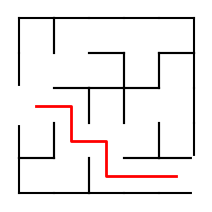

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(1, 1), MazeCell(2, 1), MazeCell(3, 1), MazeCell(4, 1), MazeCell(4, 2), MazeCell(4, 3), MazeCell(4, 4)]


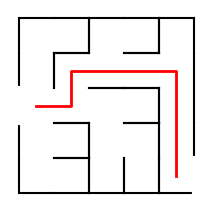

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(1, 3), MazeCell(2, 3), MazeCell(3, 3), MazeCell(4, 3), MazeCell(4, 4)]


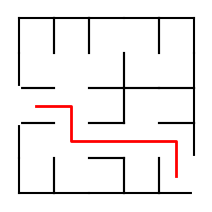

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(2, 3), MazeCell(3, 3), MazeCell(3, 4), MazeCell(4, 4)]


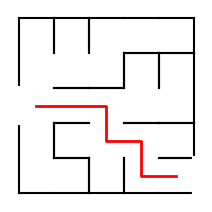

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(3, 2), MazeCell(4, 2), MazeCell(4, 3), MazeCell(4, 4)]


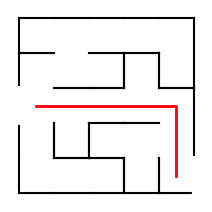

[MazeCell(0, 2), MazeCell(0, 3), MazeCell(1, 3), MazeCell(1, 2), MazeCell(2, 2), MazeCell(3, 2), MazeCell(4, 2), MazeCell(4, 3), MazeCell(4, 4)]


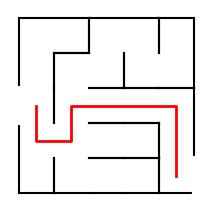

[MazeCell(0, 2), MazeCell(0, 3), MazeCell(1, 3), MazeCell(2, 3), MazeCell(3, 3), MazeCell(4, 3), MazeCell(4, 4)]


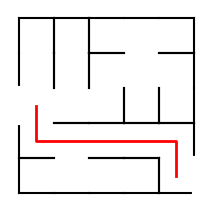

[MazeCell(0, 2), MazeCell(0, 1), MazeCell(1, 1), MazeCell(1, 2), MazeCell(2, 2), MazeCell(3, 2), MazeCell(4, 2), MazeCell(4, 3), MazeCell(4, 4)]


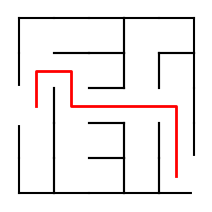

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(3, 2), MazeCell(3, 3), MazeCell(4, 3), MazeCell(4, 4)]


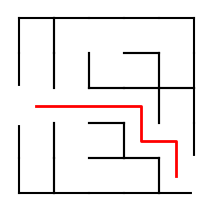

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(3, 2), MazeCell(3, 3), MazeCell(4, 3), MazeCell(4, 4)]


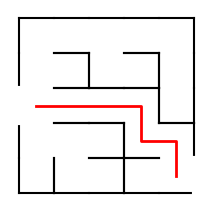

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(3, 2), MazeCell(3, 3), MazeCell(4, 3), MazeCell(4, 4)]


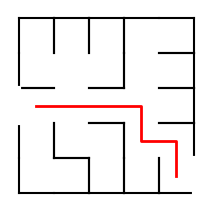

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(1, 3), MazeCell(2, 3), MazeCell(3, 3), MazeCell(4, 3), MazeCell(4, 4)]


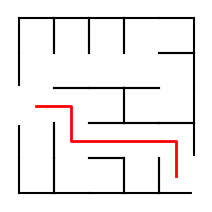

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(1, 3), MazeCell(1, 4), MazeCell(2, 4), MazeCell(3, 4), MazeCell(4, 4)]


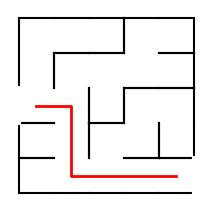

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(2, 3), MazeCell(3, 3), MazeCell(3, 2), MazeCell(4, 2), MazeCell(4, 3), MazeCell(4, 4)]


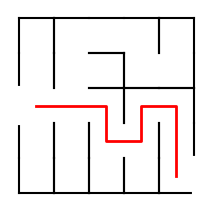

[MazeCell(0, 2), MazeCell(0, 3), MazeCell(0, 4), MazeCell(1, 4), MazeCell(1, 3), MazeCell(2, 3), MazeCell(2, 2), MazeCell(3, 2), MazeCell(4, 2), MazeCell(4, 3), MazeCell(4, 4)]


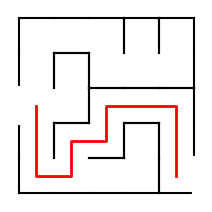

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(3, 2), MazeCell(4, 2), MazeCell(4, 3), MazeCell(4, 4)]


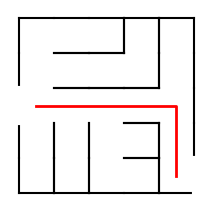

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(2, 3), MazeCell(2, 4), MazeCell(3, 4), MazeCell(4, 4)]


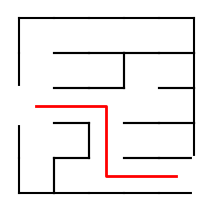

[MazeCell(0, 2), MazeCell(0, 3), MazeCell(0, 4), MazeCell(1, 4), MazeCell(2, 4), MazeCell(3, 4), MazeCell(4, 4)]


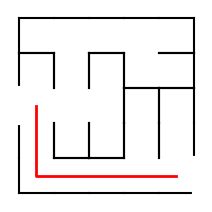

[MazeCell(0, 2), MazeCell(0, 3), MazeCell(1, 3), MazeCell(2, 3), MazeCell(3, 3), MazeCell(3, 4), MazeCell(4, 4)]


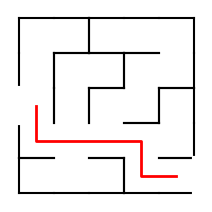

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(1, 1), MazeCell(2, 1), MazeCell(3, 1), MazeCell(3, 2), MazeCell(3, 3), MazeCell(4, 3), MazeCell(4, 4)]


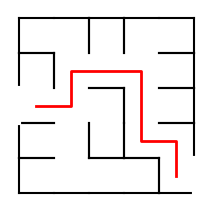

[MazeCell(0, 2), MazeCell(0, 1), MazeCell(1, 1), MazeCell(1, 2), MazeCell(1, 3), MazeCell(2, 3), MazeCell(2, 4), MazeCell(3, 4), MazeCell(4, 4)]


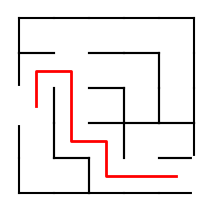

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(3, 2), MazeCell(3, 3), MazeCell(4, 3), MazeCell(4, 4)]


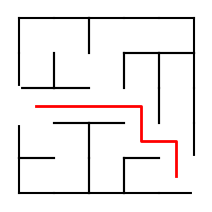

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(1, 3), MazeCell(2, 3), MazeCell(3, 3), MazeCell(3, 4), MazeCell(4, 4)]


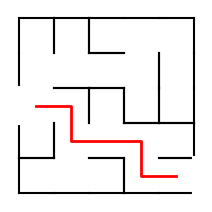

[MazeCell(0, 2), MazeCell(0, 3), MazeCell(1, 3), MazeCell(2, 3), MazeCell(3, 3), MazeCell(4, 3), MazeCell(4, 4)]


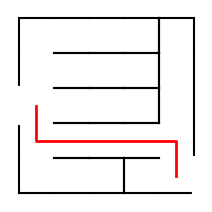

[MazeCell(0, 2), MazeCell(0, 1), MazeCell(1, 1), MazeCell(2, 1), MazeCell(2, 2), MazeCell(2, 3), MazeCell(3, 3), MazeCell(4, 3), MazeCell(4, 4)]


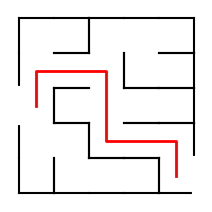

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(1, 3), MazeCell(2, 3), MazeCell(2, 4), MazeCell(3, 4), MazeCell(4, 4)]


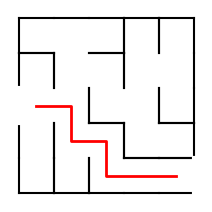

[MazeCell(0, 2), MazeCell(0, 3), MazeCell(1, 3), MazeCell(2, 3), MazeCell(2, 4), MazeCell(3, 4), MazeCell(4, 4)]


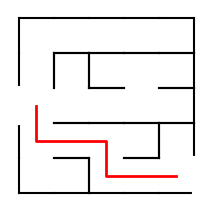

[MazeCell(0, 2), MazeCell(0, 3), MazeCell(1, 3), MazeCell(2, 3), MazeCell(2, 4), MazeCell(3, 4), MazeCell(4, 4)]


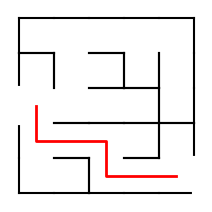

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(3, 2), MazeCell(3, 3), MazeCell(3, 4), MazeCell(4, 4)]


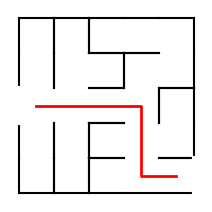

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(3, 2), MazeCell(3, 3), MazeCell(3, 4), MazeCell(4, 4)]


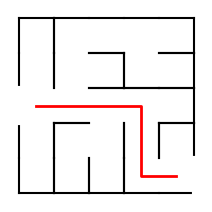

[MazeCell(0, 2), MazeCell(0, 3), MazeCell(1, 3), MazeCell(2, 3), MazeCell(3, 3), MazeCell(4, 3), MazeCell(4, 4)]


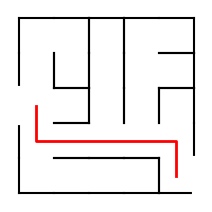

[MazeCell(0, 2), MazeCell(0, 3), MazeCell(1, 3), MazeCell(1, 4), MazeCell(2, 4), MazeCell(3, 4), MazeCell(4, 4)]


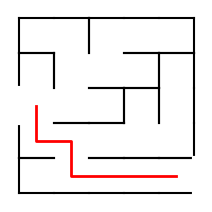

[MazeCell(0, 2), MazeCell(0, 3), MazeCell(0, 4), MazeCell(1, 4), MazeCell(2, 4), MazeCell(3, 4), MazeCell(4, 4)]


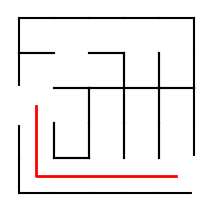

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(2, 3), MazeCell(3, 3), MazeCell(3, 4), MazeCell(4, 4)]


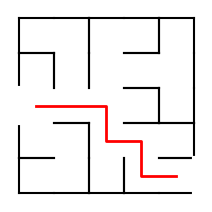

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(2, 3), MazeCell(3, 3), MazeCell(4, 3), MazeCell(4, 4)]


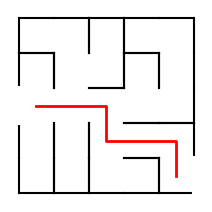

[MazeCell(0, 2), MazeCell(0, 3), MazeCell(1, 3), MazeCell(2, 3), MazeCell(2, 2), MazeCell(3, 2), MazeCell(3, 3), MazeCell(4, 3), MazeCell(4, 4)]


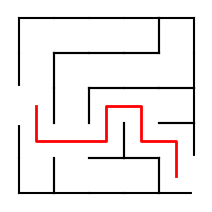

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(3, 2), MazeCell(4, 2), MazeCell(4, 3), MazeCell(4, 4)]


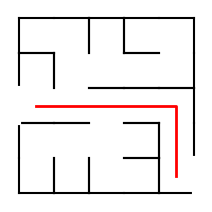

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(3, 2), MazeCell(4, 2), MazeCell(4, 3), MazeCell(4, 4)]


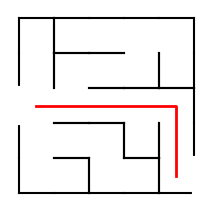

[MazeCell(0, 2), MazeCell(1, 2), MazeCell(2, 2), MazeCell(3, 2), MazeCell(3, 3), MazeCell(4, 3), MazeCell(4, 4)]


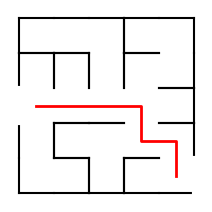

In [3]:
import maze_generator
solver = maze_generator.BFSSolver()
for i in range(100):
    maze = maze_generator.PrimGenerator().generate_maze(5,5,(0,2), (4,4))
    path = solver.solve(maze)
    maze.show(path)


In [ ]:
import os
import sys
sys.path.insert(0, os.path.abspath('utils'))
import qiskit
from qiskit.result import marginal_counts
from qiskit import QuantumCircuit, transpile
from qiskit.transpiler import CouplingMap
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Statevector # to compute state vectors
from qiskit.visualization import array_to_latex
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_aer import AerSimulator # ideal simulator backend
from qiskit.visualization import plot_histogram  # to plot histograms of simulation results
import numpy as np
from collections import namedtuple
from IPython.display import display, Markdown, Latex
import sympy as sp
from qiskit.circuit.library.standard_gates import XGate

sys.path.insert(1, '../')
from utils import Helpers as hp

In [ ]:
def map_graph(edges, registry_size: int = 2, directed: bool = False):
    circ = QuantumCircuit((2 * registry_size) + 1)
    def map_edge(from_node: int, to_node: int):
        target_qubit = (2 * registry_size)
        def add_x(number, start_qubit):
            exp = 1
            for qubit in range(start_qubit, start_qubit + registry_size):
                if not (number & exp):
                    circ.x(qubit)
                exp *= 2

        add_x(from_node, 0)
        add_x(to_node, registry_size)
        print(target_qubit)
        print(list(range((2 * registry_size))))
        circ.append(XGate().control(target_qubit), list(range((2 * registry_size))) + [target_qubit])
        add_x(from_node, 0)
        add_x(to_node, registry_size)
        
    for e in edges:
        map_edge(e[0], e[1])
        circ.barrier()
        if not directed:
            map_edge(e[1], e[0])
            circ.barrier()
    return circ



In [ ]:
# Creates a circuit that negates the input ( |x> => -I|x> )
def negate(num_qubits: int):
    n = QuantumCircuit(num_qubits)
    for i in range(num_qubits):
        n.z(i)
        n.x(i)
        n.z(i)
        n.x(i)
    return n

<IPython.core.display.Latex object>

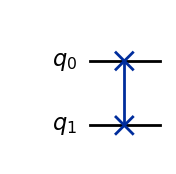

In [ ]:
#print("ciao")
qc = QuantumCircuit(2)
qc.swap(0, 1)
display(hp.derive_unitary_matrix(qc))
display(qc.draw(output='mpl'))



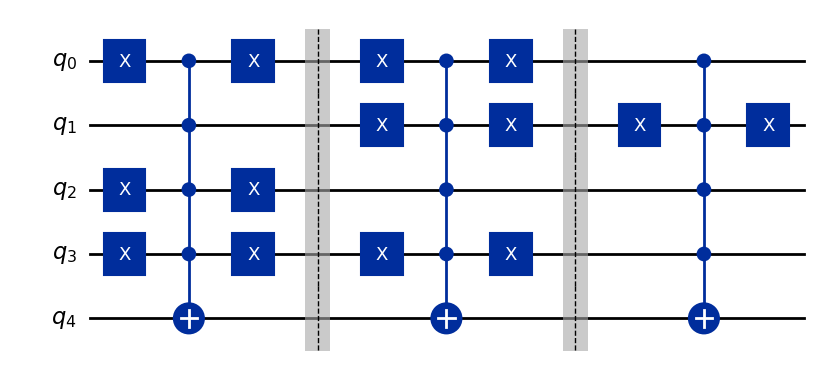

In [ ]:
check_path = QuantumCircuit(5)
# (1,0)
check_path.x(0)
check_path.x(2)
check_path.x(3)
check_path.append(XGate().control(4), [0, 1, 2, 3, 4])
check_path.x(0)
check_path.x(2)
check_path.x(3)
check_path.barrier()
# (0,2)
check_path.x(0)
check_path.x(1)
check_path.x(3)
check_path.append(XGate().control(4), [0, 1, 2, 3, 4])
check_path.x(0)
check_path.x(1)
check_path.x(3)
check_path.barrier()
# (2,3)
check_path.x(1)
check_path.append(XGate().control(4), [0, 1, 2, 3, 4])
check_path.x(1)

check_path.draw(output='mpl')

4
[0, 1, 2, 3]
4
[0, 1, 2, 3]
4
[0, 1, 2, 3]


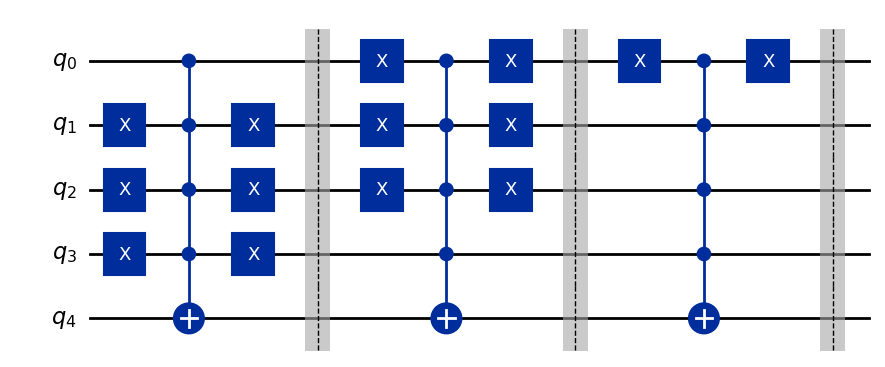

In [ ]:
map_graph([(1, 0), (0, 2), (2, 3)], directed=True).draw('mpl')

In [ ]:
from qiskit.quantum_info import Statevector # to compute state vectors
from qiskit.visualization import array_to_latex

sv = Statevector.from_label('10')
qc = QuantumCircuit(1)
qc.z(0)
qc.x(0)
qc.z(0)
qc.x(0)
# qc.append(negate, [0,1,2,3,4,5,6,7])
array_to_latex(sv.evolve(qc), prefix="\\text{Final state = }")

<IPython.core.display.Latex object>

#######
#     #
# # # #
# # # #
### # #
#   # #
#######


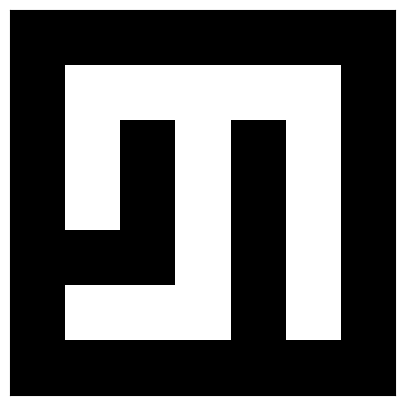

In [ ]:
from mazelib import Maze
from mazelib.generate.Prims import Prims

m = Maze()
m.generator = Prims(3, 3)
m.generate()
print(m)
import matplotlib.pyplot as plt

def showPNG(grid):
    """Generate a simple image of the maze."""
    plt.figure(figsize=(10, 5))
    plt.imshow(grid, cmap=plt.cm.binary, interpolation='nearest')
    plt.xticks([]), plt.yticks([])
    plt.show()
showPNG(m.grid)

In [ ]:

# # from __future__ import absolute_import
# from src.maze_manager import MazeManager
# from src.maze import Maze


# if __name__ == "__main__":

#     # The easiest way to use the library is through the Manager class. It acts as the glue between
#     # The visualization, solver, and maze classes. Mazes inside the manager have unique ids that we use
#     # to specify particular mazes.
#     manager = MazeManager()

#     # We can add mazes to the manager two different ways.
#     # The first way, we specify the maze dimensions. The maze that is created gets returned back to you.
#     maze = manager.add_maze(10, 10)

#     # The second way is by creating a maze, and then adding it to the manager. Doing this will require you to add
#     # from src.maze import Maze
#     # to your imports. Because the ids need to be unique, the manager will ensure this happens. It may change the
#     # id of the maze that was passed in, so we assign it to the return value to make sure we're using the updated maze.
#     maze2 = Maze(10, 10)
#     maze2 = manager.add_existing_maze(maze2)

#     # Once we have a maze in the manager, we can tell the manager to solve it with a particular algorithm.
#     #manager.solve_maze(maze.id, "BreadthFirst")
#     #manager.solve_maze(maze.id, "BiDirectional")
#     manager.solve_maze(maze.id, "DepthFirstBacktracker")

#     # If we want to save the maze & maze solution images along with their animations, we need to let the manager know.
#     manager.set_filename("myFileName")

#     # To see the unsolved maze, call
#     manager.show_maze(maze.id)

#     # You can also set the size of the cell by passing show_maze's second argument. The default is 1.
#     # manager.show_maze(maze.id, 2)

#     # To show an animation of how the maze was generated, use the following line
#     manager.show_generation_animation(maze.id)

#     # You can also see an animation of how the solver went about finding the end
#     manager.show_solution_animation(maze.id)

#     # Finally, you can show an image of the maze with the solution path overlaid. All of these display
#     # functions will save the figure if MazeManager::set_filename has been set.
#     manager.show_solution(maze.id)

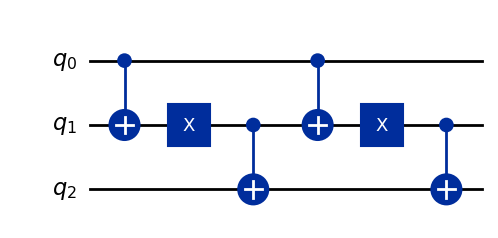

<IPython.core.display.Latex object>

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister

# Qubit: 3 controlli + 1 target ancilla
# qr = QuantumRegister(4)
qc = QuantumCircuit(3)

qc.cx(0,1)
qc.x(1) 
qc.cx(1,2)

qc.cx(0,1)
qc.x(1)  
qc.cx(1,2)


display(qc.draw('mpl'))
inp = Statevector.from_label('000')
out = inp.evolve(qc)
display(hp.print_statevector(out))


In [ ]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector, partial_trace
import numpy as np

def test_input(input_bits):
    qr = QuantumRegister(4)
    qc = QuantumCircuit(qr)

    # Inizializza i primi 3 qubit nello stato input_bits
    for i, bit in enumerate(input_bits):
        if bit == '1':
            qc.x(qr[i])

    # Compute
    qc.mcx([qr[0], qr[1]], qr[3])
    qc.mcx([qr[1], qr[2]], qr[3])

    # Uncompute (ordine inverso!)
    qc.mcx([qr[0], qr[1]], qr[3])
    qc.mcx([qr[1], qr[2]], qr[3])

    # Simula stato finale
    state = Statevector.from_instruction(qc)

    # Trace out primi 3 qubit per vedere stato ancilla
    ancilla_state = partial_trace(state, [0,1,2])

    # Probabilità ancilla in |0>
    p0 = np.real(ancilla_state.data[0,0])
    print(f"Input: {input_bits} -> Probabilità ancilla |0> = {p0:.4f}")

# Test su tutti i casi
for bits in ['000', '100', '010', '001', '110', '011', '111']:
    test_input(bits)


Input: 000 -> Probabilità ancilla |0> = 1.0000
Input: 100 -> Probabilità ancilla |0> = 1.0000
Input: 010 -> Probabilità ancilla |0> = 1.0000
Input: 001 -> Probabilità ancilla |0> = 1.0000
Input: 110 -> Probabilità ancilla |0> = 1.0000
Input: 011 -> Probabilità ancilla |0> = 1.0000
Input: 111 -> Probabilità ancilla |0> = 1.0000


In [ ]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector, partial_trace
import numpy as np

def test_order(input_bits, uncompute_order_inverted=True):
    qr = QuantumRegister(5)  # 3 controlli + 2 ancilla
    qc = QuantumCircuit(qr)

    # Inizializza primi 3 qubit
    for i, bit in enumerate(input_bits):
        if bit == '1':
            qc.x(qr[i])

    # Compute
    qc.mcx([qr[0], qr[1]], qr[3])  # MCX_1 su ancilla 0
    qc.mcx([qr[1], qr[2]], qr[4])  # MCX_2 su ancilla 1

    # Uncompute
    if uncompute_order_inverted:
        # Ordine inverso corretto
        qc.mcx([qr[1], qr[2]], qr[4])  # MCX_2 uncompute
        qc.mcx([qr[0], qr[1]], qr[3])  # MCX_1 uncompute
    else:
        # Ordine sbagliato (stesso ordine del compute)
        qc.mcx([qr[0], qr[1]], qr[3])  # MCX_1 uncompute
        qc.mcx([qr[1], qr[2]], qr[4])  # MCX_2 uncompute

    # Simula stato finale
    state = Statevector.from_instruction(qc)

    # Traccia le ancilla (q3 e q4)
    ancilla_state = partial_trace(state, [0,1,2])

    # Probabilità degli stati |00>,|01>,|10>,|11>
    probs = np.real(np.diag(ancilla_state.data))

    print(f"Input: {input_bits} - Uncompute inverso? {uncompute_order_inverted}")
    print(f"Prob ancilla (|00>,|01>,|10>,|11>) = {probs}")
    print(f"Ancilla sono tornate a |00>? {'Yes' if np.isclose(probs[0],1) else 'No'}\n")

t = '101'
# Proviamo con input '110'
print("Con uncompute ordine inverso (corretto):")
test_order(t, uncompute_order_inverted=True)

print("Con uncompute stesso ordine (sbagliato):")
test_order(t, uncompute_order_inverted=False)


Con uncompute ordine inverso (corretto):
Input: 101 - Uncompute inverso? True
Prob ancilla (|00>,|01>,|10>,|11>) = [1. 0. 0. 0.]
Ancilla sono tornate a |00>? Yes

Con uncompute stesso ordine (sbagliato):
Input: 101 - Uncompute inverso? False
Prob ancilla (|00>,|01>,|10>,|11>) = [1. 0. 0. 0.]
Ancilla sono tornate a |00>? Yes



In [ ]:
class MyClass:
    def __init__(self, a: int, b: int):
        self.__a = a
        self.__b = [1]

    @property
    def a(self):
        return self.__a
    @property
    def b(self):
        return list(self.__b)
    
    def __repr__(self):
        return f"MyClass(a={self.a}, b={self.b})"

obj = MyClass("qqsada", 2)
obj._a = 3
obj.b.append(2)

print(obj)  # MyClass(a=1, b=2)
o = []
print(o[1])    

MyClass(a=qqsada, b=[1])


IndexError: list index out of range